In [3]:
# Basic utilities
import re
import sys
from datetime import date
from copy import deepcopy
import matplotlib.pyplot as plt

# Data wrangling packages
import numpy as np
from scipy import stats

# Cellpose - the current belle of the ball
from cellpose import models, io

# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Cell Segmentation', 'Imaging Utilities', str(sys.path[0]))

# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
import ims_file_utils as ims
import image_processing_utils as impro
from skimage.segmentation import find_boundaries
import cv2
import pandas as pd
import scipy.ndimage as ndimage
from skimage import io
import glob
import pickle as pkl
import os, psutil
process = psutil.Process(os.getpid())
# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Registration', 'Imaging Utilities', str(sys.path[0]))
# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
import ims_file_utils as ims
import image_processing_utils as impro
import plotting_funcs_BEpilot as plot
from functools import reduce
from scipy.spatial.distance import cdist, pdist
from skimage.exposure import rescale_intensity

# Import cell segmentation images

In [5]:
import glob
# All files and directories ending with .txt and that don't begin with a dot:
opdir = "/mnt/disks/external/jg4159/20220718_coculture/"
file_list = glob.glob(opdir+"*P3_R0*FusionStitcher.ims")
file_list.sort()
for f in file_list:
    print(f)

/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_B2_2022-07-18_20220718_jg4159_coc_P3_B2_20.56.41_FusionStitcher.ims
/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_B3_2022-07-18_20220718_jg4159_coc_P3_B3_20.52.08_FusionStitcher.ims
/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_E2_2022-07-18_20220718_jg4159_coc_P3_E2_20.41.44_FusionStitcher.ims
/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_E3_2022-07-18_20220718_jg4159_coc_P3_E3_20.46.58_FusionStitcher.ims
/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_F2_2022-07-18_20220718_jg4159_coc_P3_20.36.52_FusionStitcher.ims
/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_F3_2022-07-18_20220718_jg4159_coc_P3_20.25.10_FusionStitcher.ims
/mnt/disks/external/jg4159/20220718_coculture/20220718_jg4159_coculture_P3_R0_G2_2022-07-18_20220718_jg4159_coc_P3_G2_20.07.34_Fus

# batch processing and reporting

In [ ]:
import time
import re
import gc

for f in file_list:
    start_time = time.time()
    runName = re.findall('jg4159_(.*)_2022-0', f)[0]
    print("runName:", runName)
    well_id = re.findall('R0_(.*)_2022-0', f)[0]
    print("well id: ", well_id)
    #load image
    ip=glob.glob(opdir+'20220718_coculture_P3_'+well_id+'*segmentation_*.pickle')[0]
    print(ip)
    filehandler = open(ip, 'rb')
    masks_mem, masks_nuc, max_img, ref_mem = pkl.load(filehandler)
    filehandler.close()

    # find centroids for all cells
    img_x = max_img.shape[0]
    print(img_x)
    for key in ref_mem.keys(): # use keys in the saved dict
        nuc_arr = ref_mem[key]['Nuclei Pixels']
        x = np.mean([int(j/img_x) for j in nuc_arr])
        y = np.mean([j%img_x for j in nuc_arr])   
        sub_dict1 = dict()
        sub_dict1['centroid_x'] = x
        sub_dict1['centroid_y'] = y
        ref_mem[key].update(sub_dict1)

    # select large (melanoma) and small (T-cell) cells
    nuc_size_threshold = 200 # based on nuclei size histogram
    nucVals = np.array([len(ref_mem[nuc]['Nuclei Pixels']) for nuc in ref_mem])
    nucPos = np.array(list(ref_mem.keys()))[nucVals>=nuc_size_threshold]
    print("large cells:", len(nucPos))
    nucNeg = np.array(list(ref_mem.keys()))[nucVals<nuc_size_threshold]
    print("small cells:", len(nucNeg))

    # plot centroids
    fig, ax = plt.subplots(figsize=(50, 50))
    ax.set_aspect('auto')
    ax.imshow(find_boundaries(masks_mem)) #preferable to adjust contrast prior to plotting, use cmap to choose colors
    # to plot only large nuclei
    all_large_centroid = np.zeros(shape=(0,3))
    for i, nuc in enumerate(nucPos):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='red', linewidth=2, fill=False)
        spot = [x,y,1]
        all_large_centroid = np.append(all_large_centroid, [spot], axis=0)
        ax.add_patch(c)


    # to plot only small nuclei
    all_small_centroid = np.zeros(shape=(0,3))
    for i, nuc in enumerate(nucNeg):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='blue', linewidth=2, fill=False)
        spot = [x,y,1]
        all_small_centroid = np.append(all_small_centroid, [spot], axis=0)
        ax.add_patch(c)


    #separate masks_mem into large and small
    masks_mem_large = copy.deepcopy(masks_mem)
    for i in range(masks_mem_large.shape[0]):
        masks_mem_large[i]  = masks_mem_large[i] * np.isin(masks_mem_large[i], nucPos)
    masks_mem_small = copy.deepcopy(masks_mem)
    for i in range(masks_mem_small.shape[0]):
        masks_mem_small[i]  = masks_mem_small[i] * np.isin(masks_mem_small[i], nucNeg)

    # dialate large masks
    radius=3
    outl = find_boundaries(masks_mem_large, connectivity=1, mode='thick', background=0)
    outl_mask = masks_mem_large #Use this for outline with color scheme similar to the cell mask
    #Creating a kernel to add pixels of desired size
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    #adding pixels to foreground -- will only work on binary images --- use following command to change thickness
    thick_outl = cv2.dilate(outl_mask.astype(np.uint16), kernel, iterations=radius) #Vary iterations parameter for varying thickness 

    # find overlapping
    thick_outl_flat = thick_outl.ravel()
    masks_mem_small_flat = masks_mem_small.ravel()
    unique_large = np.sort(np.unique(thick_outl_flat))
    unique_large = unique_large[1:]
    #print(len(unique_large))
    identified_small = []
    for key in ref_mem.keys(): # use keys in the saved dict
        sub_dict1 = dict()
        if key in unique_large:
            #print(key)
            sub_dict1['cell_size'] = 'large'
            small_overlap = np.unique(masks_mem_small_flat[np.where(thick_outl_flat==key)])
            small_overlap = small_overlap[small_overlap != 0]
            if len(small_overlap) > 0: # have overlapped small masks
                sub_dict1['overlapped_small_id'] = list(small_overlap)
                sub_dict1['number_overlap_small'] = len(small_overlap)
                identified_small.extend(list(small_overlap))
            else: # no overlapped small masks
                sub_dict1['overlapped_small_id'] = []
                sub_dict1['number_overlap_small'] = 0
        else: # is a small cell
            sub_dict1['cell_size'] = 'small'
            sub_dict1['overlapped_small_id'] = []
            sub_dict1['number_overlap_small'] = 0
        ref_mem[key].update(sub_dict1)

    # summarize
    data = []
    for key in ref_mem.keys(): # use keys in the saved dict
        data.append([key, len(ref_mem[key]['Nuclei Pixels']),len(ref_mem[key]['Membrane Pixels']), ref_mem[key]['cell_size'], ref_mem[key]['number_overlap_small']])

    df2 = pd.DataFrame(data, columns=['cell_id', "nuc_size", "mem_size", 'cell_size', 'number_overlap_small'])
    df2 = df2.sort_values(by="cell_id")
    # save df
    df2.to_csv(opdir + "Overlap_small_cells_"+ well_id + "_" + str(date.today()) + '.csv', index=False)
    # save ref_mem
    filehandler = open(opdir + runName + "_overlap_ref_mem_" + str(date.today()) + '.pickle', 'wb')
    pkl.dump((ref_mem), filehandler)
    filehandler.close()
    
    a = df2.number_overlap_small.values
    print("overlapped cells:", len(a[a!=0]), "/", len(a), "=", len(a[a!=0])/len(a))
    print("Mean =", np.mean(a),";", "Maximum =", np.amax(a))
    
    identified_small= np.unique(identified_small)
    print("small cells identified:", len(identified_small))
    all_small = np.unique(masks_mem_small_flat[masks_mem_small_flat!=0])
    #print(len(all_small))
    unidentified_small = np.setdiff1d(all_small,identified_small,  assume_unique=True)
    print("small cells unidentified:", len(unidentified_small))
    
    ## Visualization
    # plot centroids
    fig, ax = plt.subplots(figsize=(50, 50))
    ax.set_aspect('auto')
    ax.imshow(find_boundaries(masks_mem)) #preferable to adjust contrast prior to plotting, use cmap to choose colors
    # to plot all large nuclei
    for i, nuc in enumerate(nucPos):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='red', linewidth=2, fill=False)
        ax.add_patch(c)

    # to plot only small nuclei identified
    id_small_centroid = np.zeros(shape=(0,3))
    for i, nuc in enumerate(identified_small):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='yellow', linewidth=2, fill=False)
        spot = [x,y,1]
        id_small_centroid = np.append(id_small_centroid, [spot], axis=0)
        ax.add_patch(c)
        
    # to plot all small nuclei
    unid_small_centroid = np.zeros(shape=(0,3))
    for i, nuc in enumerate(unidentified_small):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='blue', linewidth=2, fill=False)
        spot = [x,y,1]
        unid_small_centroid = np.append(unid_small_centroid, [spot], axis=0)
        ax.add_patch(c)
        
    filehandler = open(opdir+'all_large_centroid' + "_" + runName + '.pkl', 'wb')
    pkl.dump(all_large_centroid, filehandler)
    filehandler.close()
    filehandler = open(opdir+'all_small_centroid' + "_" + runName + '.pkl', 'wb')
    pkl.dump(all_small_centroid, filehandler)
    filehandler.close()
    filehandler = open(opdir+'id_small_centroid' + "_" + runName + '.pkl', 'wb')
    pkl.dump(id_small_centroid, filehandler)
    filehandler.close()
    filehandler = open(opdir+'unid_small_centroid' + "_" + runName + '.pkl', 'wb')
    pkl.dump(unid_small_centroid, filehandler)
    filehandler.close()
    
    print("=====================================================================================")

# Example visualization from one well

 - red: centroid of melanoma cells
 - blue: centroid of melanoma cells not touching any melanoma cells
 - yellow: centroid of melanoma cells touching melanoma cells

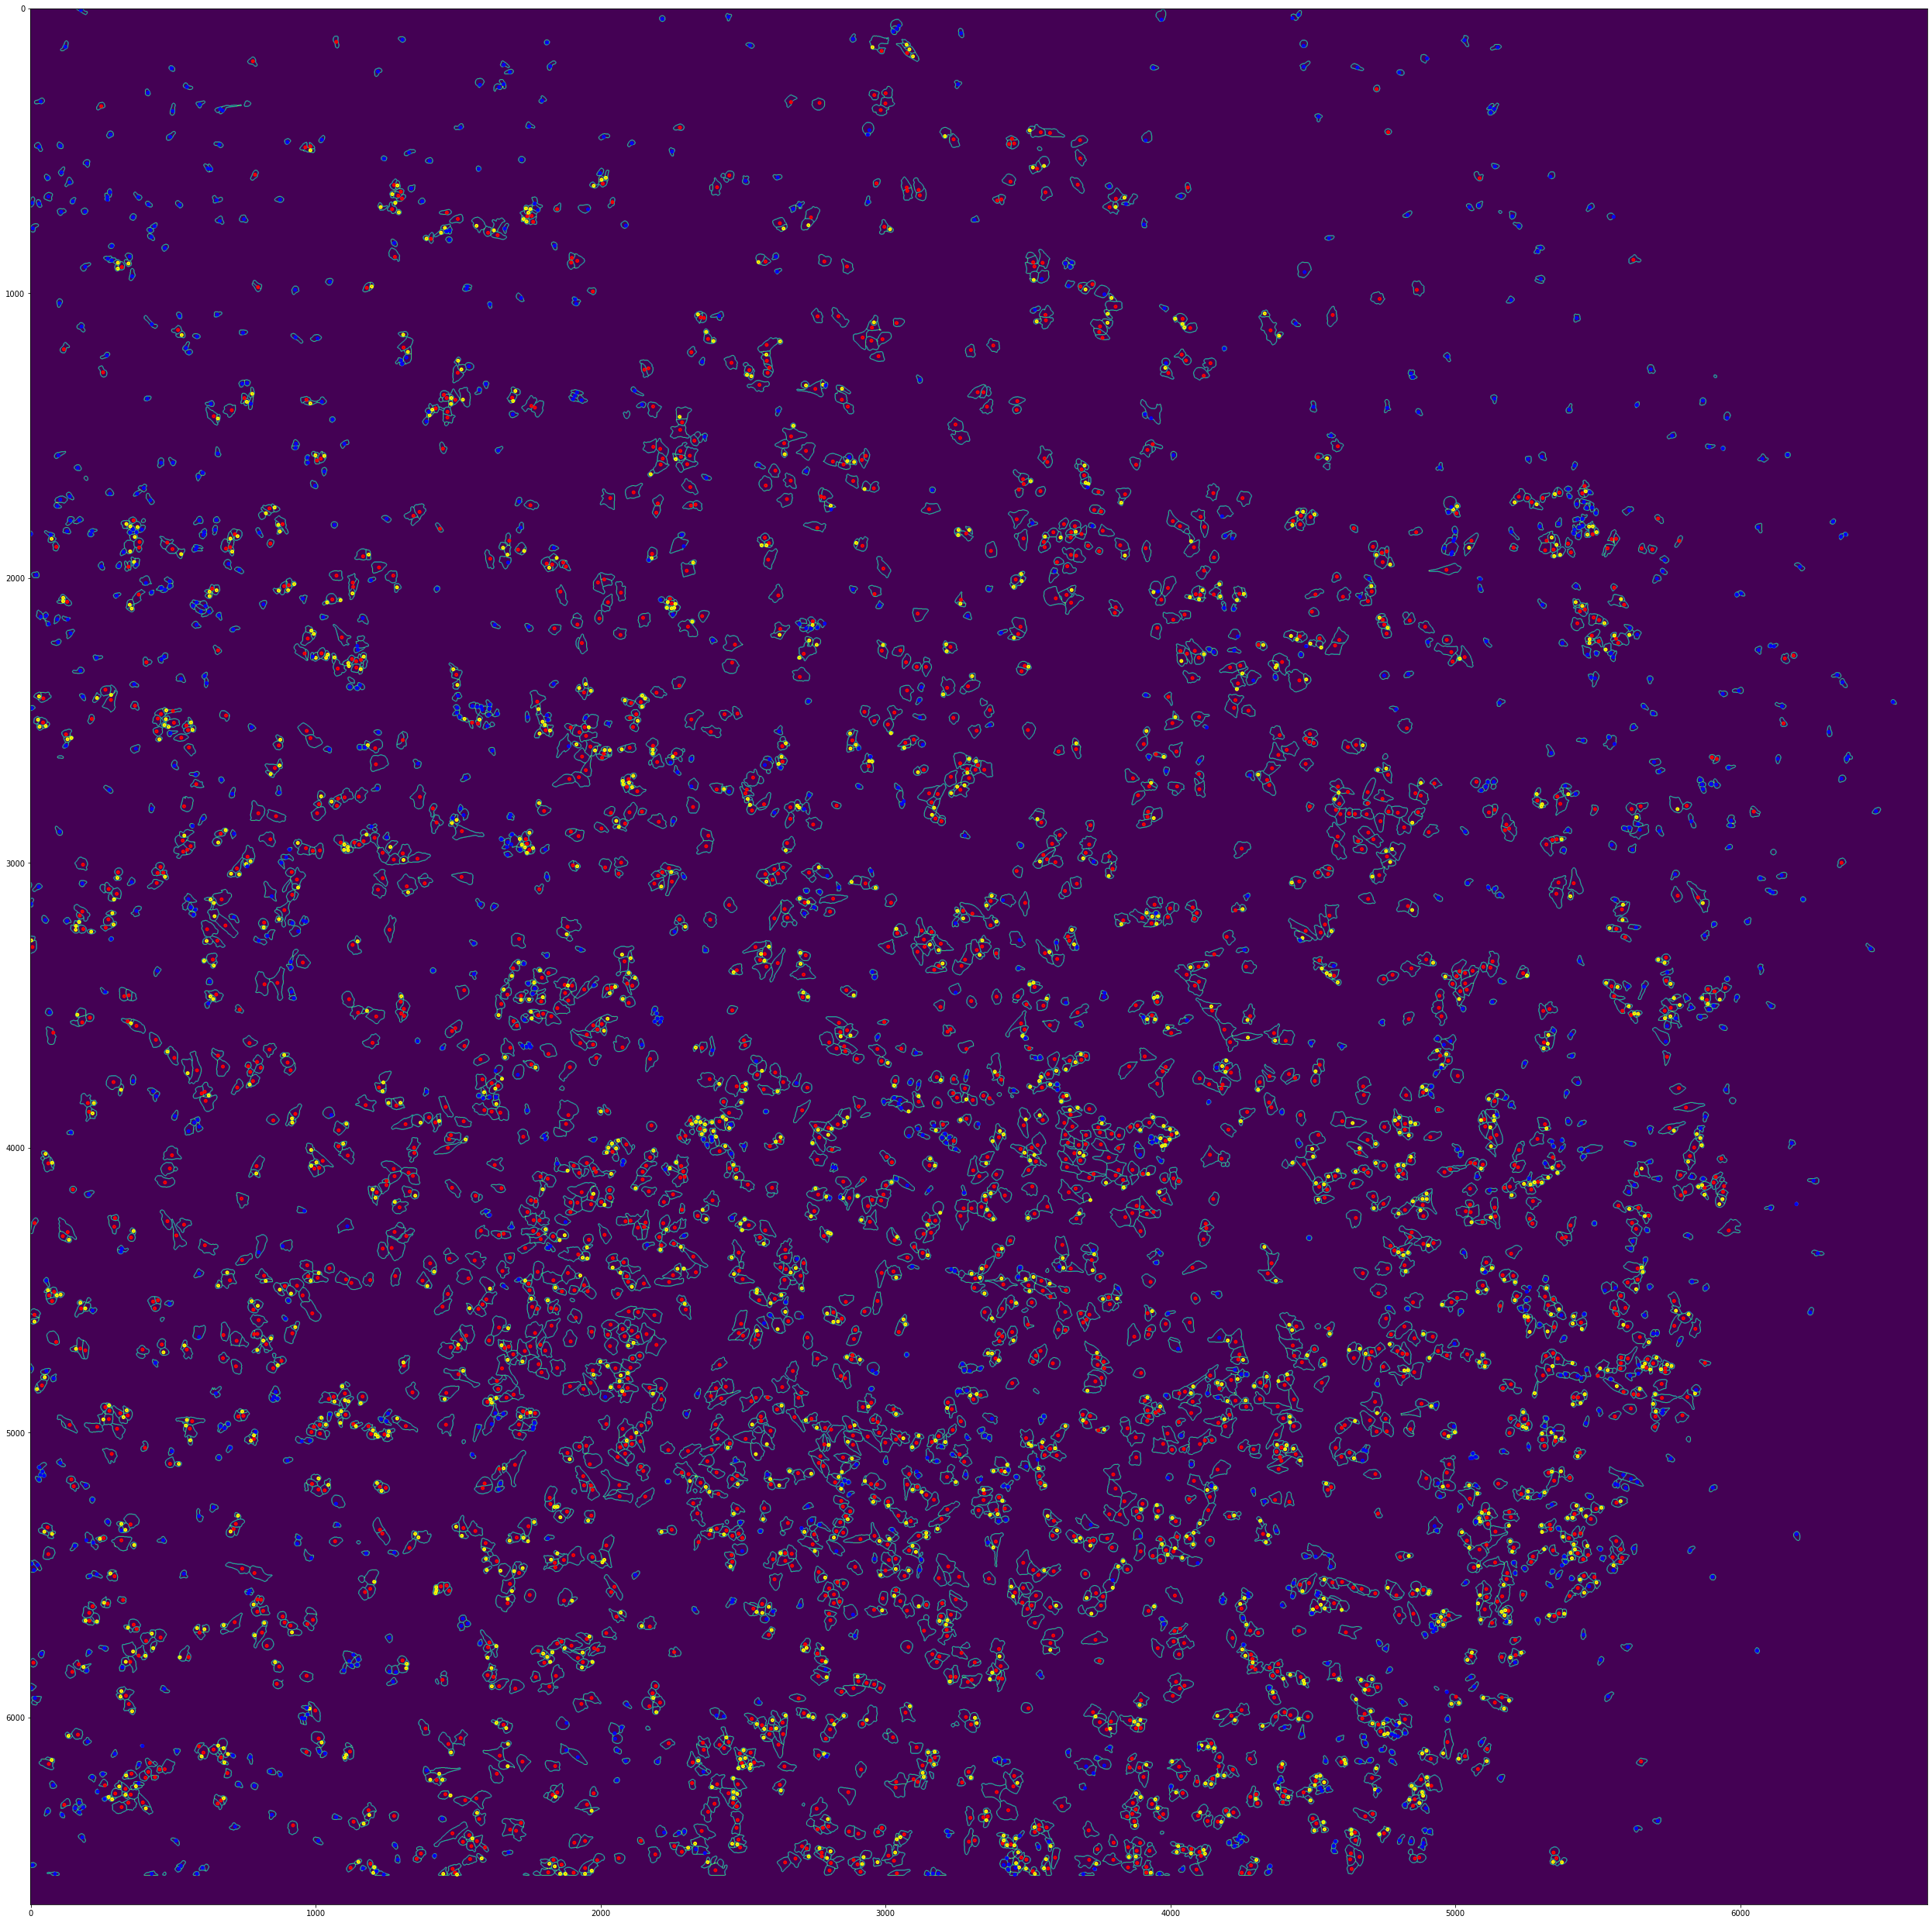

In [75]:
    # plot centroids
    fig, ax = plt.subplots(figsize=(45, 45))
    ax.set_aspect('auto')
    ax.imshow(find_boundaries(masks_mem)) #preferable to adjust contrast prior to plotting, use cmap to choose colors
    # to plot only large nuclei
    for i, nuc in enumerate(nucPos):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='red', linewidth=2, fill=False)
        ax.add_patch(c)

    # to plot only small nuclei identified
    for i, nuc in enumerate(identified_small):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='yellow', linewidth=2, fill=False)
        ax.add_patch(c)
        
    # to plot only small nuclei
    for i, nuc in enumerate(unidentified_small):
        x = ref_mem[nuc]['centroid_x']
        y = ref_mem[nuc]['centroid_y']
        c = plt.Circle((y,x), 4, color='blue', linewidth=2, fill=False)
        ax.add_patch(c)